In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from args import TrendArgs
from company import Company
import twitter_grabber as tw_grabber
from datetime import datetime, timedelta
from twitter_sentiment import TwitterSentimentModel
from bert_args import TrainingArguments

In [2]:
companies = pd.read_csv("../dataset/companies.csv")
companies = dict(zip(companies.symbol, companies.name))

In [3]:
args = TrendArgs()
args.stock_dataset = "../" + args.stock_dataset
args.model_path = "../" + args.model_path

In [4]:
def select_best_companies(companies_symbols, days, max_loss=0.05):
    portfolio = []
    for symbol in tqdm(companies_symbols):
        try:
            company = Company(symbol, args)
            company.load_data()
            company.load_model()
            history = np.array(company.data.Close[-days - args.seq_window:])
            pred_price = company.predict(history[:10])[0]
            price = history[9]
            delta = pred_price - price
            if delta > 0:
                company.init_train_test_data()
                loss = company.test()
                if loss < max_loss:
                    portfolio += [(symbol, round(delta*100/price, 2))]
        except FileNotFoundError:
            pass
    return portfolio

In [5]:
portfolio = select_best_companies(companies.keys(), 2)
portfolio = sorted(portfolio, key=lambda a: a[1], reverse=True)
len(portfolio)

100%|██████████| 505/505 [01:18<00:00,  6.41it/s]


192

In [6]:
def stock_analise(company_name, days=10, show=False):
    company = Company(company_name, args)
    company.load_data()
    company.load_model()
    company.init_train_test_data()
    print("model loss", company.test())
    history = np.array(company.data.Close[-days - args.seq_window:])
    y_pred = company.predict(history[:10], days)
    y_pred = np.insert(y_pred, 0, history[9])
    pred_lin_model = LinearRegression().fit(np.arange(9, 10+days).reshape(-1, 1), y_pred)
    
    lin_model = LinearRegression().fit(np.arange(10).reshape(-1, 1), history[:10])
    coef_10 = lin_model.coef_
    y_lin_10 = lin_model.predict(np.arange(10 + days).reshape(-1, 1))
    lin_model = LinearRegression().fit(np.arange(5, 10).reshape(-1, 1), history[5:10])
    coef_5 = lin_model.coef_
    y_lin_5 = lin_model.predict(np.arange(10 + days).reshape(-1, 1))
    y_pred_lin_10 = pred_lin_model.predict(np.arange(10 + days).reshape(-1, 1))
    coef_pred = pred_lin_model.coef_
    x = company.data.Date[-args.seq_window-days:]
    plt.plot(x, y_lin_10, linestyle='dashdot', color="silver", label='y10')
    plt.plot(x, y_pred_lin_10, color='pink', label='p10')
    plt.plot(x, y_lin_5, linestyle='dashed', color="silver", label='y5')
    plt.plot(x[:-days], history[:-days], color='black')
    plt.xticks(rotation='vertical')
    if show:
        plt.plot(x[9:], history[9:])
    plt.plot(np.arange(9, 10 + days), y_pred, color='r')
    plt.legend(loc=4)
    plt.show()
    return coef_10[0], coef_5[0], coef_pred[0]


NBL Noble Energy Inc
model loss 0.038692255830219915
(-0.03612125281131625, -0.06900005340576174, 0.04889447348458427)


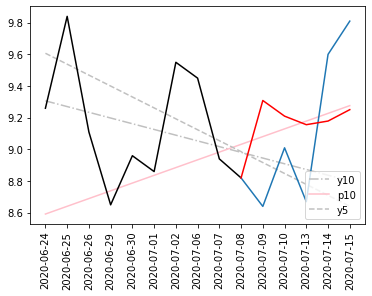

In [59]:
company_symbol = portfolio[9][0]
print(company_symbol, companies[company_symbol])
print(stock_analise(company_symbol, 5, True))

In [57]:
tweets = tw_grabber.grab_tweets("$" + company_symbol, 20, 100)
tweets = tweets[["date", "text"]]
tweets.date = pd.to_datetime(tweets.date) 
tweets.date = tweets.date.map(lambda d: d.date())

--querysearch "$NBL" --lang en --maxtweets 100 --output D:\nikita\twitter_stock\stock_recom\dataset\twitter\companies\temp.csv --since 2020-06-30 --until 2020-07-01
2020-06-30 2020-07-01
--querysearch "$NBL" --lang en --maxtweets 100 --output D:\nikita\twitter_stock\stock_recom\dataset\twitter\companies\temp.csv --since 2020-07-01 --until 2020-07-02
2020-07-01 2020-07-02
--querysearch "$NBL" --lang en --maxtweets 100 --output D:\nikita\twitter_stock\stock_recom\dataset\twitter\companies\temp.csv --since 2020-07-02 --until 2020-07-03
2020-07-02 2020-07-03
--querysearch "$NBL" --lang en --maxtweets 100 --output D:\nikita\twitter_stock\stock_recom\dataset\twitter\companies\temp.csv --since 2020-07-03 --until 2020-07-04
2020-07-03 2020-07-04
--querysearch "$NBL" --lang en --maxtweets 100 --output D:\nikita\twitter_stock\stock_recom\dataset\twitter\companies\temp.csv --since 2020-07-04 --until 2020-07-05
2020-07-04 2020-07-05
--querysearch "$NBL" --lang en --maxtweets 100 --output D:\nikita

In [27]:
bert_args = TrainingArguments()
bert_args.output_dir = "../" + bert_args.output_dir
twitter_sent_model = TwitterSentimentModel(bert_args)

In [63]:
tweet_anal = {}
day = datetime(2020, 6, 30)
for i in range(20):    
    day_tweets = set(tweets[tweets.date == day.date()].text.tolist())
    if len(day_tweets) == 0: continue
    day = day + timedelta(1)    
    tweet_anal[day] = np.median(twitter_sent_model.analyze(day_tweets))
    print(day.date().isoformat(), len(day_tweets), tweet_anal[day])

2020-07-01 15 0.83004886
2020-07-02 16 0.9322041
2020-07-03 19 0.80660963
2020-07-04 16 0.8785653
2020-07-05 11 0.51650983
2020-07-06 6 0.8737206
2020-07-07 17 0.79508996
2020-07-08 13 0.78376377
2020-07-09 14 0.9821562
2020-07-10 25 0.92137957
2020-07-11 26 0.8908248
2020-07-12 8 0.72389376
2020-07-13 11 0.81876224
2020-07-14 27 0.87676734
2020-07-15 35 0.87827766
2020-07-16 21 0.8974947
2020-07-17 30 0.8683595
2020-07-18 10 0.74168336
2020-07-19 7 0.71646214
2020-07-20 5 0.70503736


In [64]:
for d, val in tweet_anal.items():
    print(d.date().isoformat(), val)
tweets

2020-07-01 0.83004886
2020-07-02 0.9322041
2020-07-03 0.80660963
2020-07-04 0.8785653
2020-07-05 0.51650983
2020-07-06 0.8737206
2020-07-07 0.79508996
2020-07-08 0.78376377
2020-07-09 0.9821562
2020-07-10 0.92137957
2020-07-11 0.8908248
2020-07-12 0.72389376
2020-07-13 0.81876224
2020-07-14 0.87676734
2020-07-15 0.87827766
2020-07-16 0.8974947
2020-07-17 0.8683595
2020-07-18 0.74168336
2020-07-19 0.71646214
2020-07-20 0.70503736


,date,text
0,2020-06-30,"Tuesday's Top Flow in #energy sector, Buy Flow..."
1,2020-06-30,Short sale volume (not short interest) for $AP...
2,2020-06-30,$NBL short % to float is 5.16% http://sunshine...
3,2020-06-30,$NBL enters a Downtrend as Momentum Indicator ...
4,2020-06-30,Do you like $NBL? I like the looks of it long ...
...,...,...
328,2020-07-19,A Beginner’s Guide to Stock Investing. On Amaz...
329,2020-07-19,2020-07-17 Short sale volume (not short intere...
330,2020-07-19,$NBL in Uptrend: Stochastic indicator is remai...
331,2020-07-19,4 months later $lwp is on the list of 5 non #b...


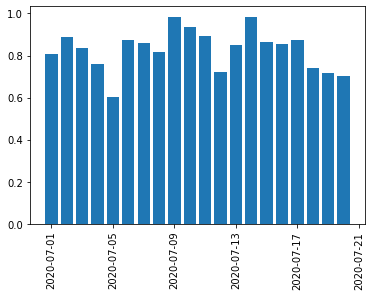

In [49]:
x = tweet_anal.keys()
y = tweet_anal.values()

plt.bar(x, y)
plt.xticks(rotation='vertical')
plt.show()

In [12]:
df = pd.read_csv('../dataset/yahoo/' + company_symbol + '.csv')

In [15]:
# my_portfolio = {
#     'ABMD': 1, 'AAP': 1, 'AEP': 1
# }
# 

In [16]:
# def portfolio_value(my_portfolio, days):
#     total = 0
#     for company_name, n in my_portfolio.items():
#         company = Company(company_name, args)
#         company.load_data()
#         total += company.data.Close.tolist()[-days-1] * n
#         print(company_name, company.data.Close.tolist()[-n])
#     print(total)
#     return total
# 

In [17]:
# stock_value = portfolio_value(my_portfolio, 10)
# cash = 500 - stock_value
# 

In [18]:
# days = 1
# for company_name in my_portfolio.keys():
#     print(company_name)
#     k1, k2, k_p = stock_analise(company_name, days)
#     if k_p > 0 and (k1 > 0 or k2 > 0):
#         print("покупать")
#     else:
#         print("продать")
# 

In [19]:
# def sell(my_portfolio, sell_stock):
#     cash = 0
#     for company_name in sell_stock:
#         company = Company(company_name, args)
#         company.load_data()
#         cash += company.data.Close.tolist()[-days-1] * my_portfolio[company_name]
#         del my_portfolio[company_name]
#     return cash
# 
# 

In [20]:
# # cash += sell(my_portfolio, ['AAP'])
# stock_value = portfolio_value(my_portfolio, days)
# print(stock_value + cash)
